# Анонимизированные и преобразованные данные по заказам интернет-магазина

`df_train.csv` и `df_test.csv` - таблицы с данными.

## Задача: предсказать расходы за отказ от покупки конкретного товара (колонка `item_losses`).

Для файла `df_test.csv` также требуется предсказать целевую переменную (предсказание сохранить в колонке `y_pred` в `csv` файле с сохранением порядка строк как в `df_test.csv`).

## Качество предсказаний будет проверяться на тестовых данных `df_test.csv` по метрике `RMSE`.

**Описание данных:**

`order_id` - id заказа

`departure_country` - id страны отправления заказа

`departure_city` - id города отправления заказа

`departure_region` - id региона города отправления заказа

`arrival_country` - id страны получения заказа

`arrival_city` - id города получения заказа

`arrival_region` - id региона города получения заказа

`order_date` - дата заказа

`stock_departure_date` - время отправки со склада

`delivery_service_departure_date` - время отправки службой доставки

`client_arrival_date` - время доставки заказа в пункт получения

`item_type` - тип товара (для кого предназначен)

`client_keywords` - запрос для перехода клиента

`client_device_type` - устройство клиента

`client_browser` - браузер клиента

`item_package_type` - способ упаковки

`client_is_app` - заказ из приложения

`order_tracking_available` - отслеживание заказа

`brand_name` - название бренда

`item_id` - id товара

`item_category` - категория товара

`delivery_service_name` - название службы доставки

`type_prepayment` - тип предоплаты

`item_price` - цена товара

`item_losses` - расходы за отказ от покупки (целевая переменная)

# Тестовое задание

## 1. Загрузка и первичный анализ данных
- Читаем данные `df_train.csv` и `df_test.csv`.
- Смотрим размеры, пропуски, базовую статистику.

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import math
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer                     
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, precision_score, confusion_matrix, recall_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

RANDOM_STATE = 30625
TEST_SIZE = 0.25

In [2]:
import ast

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
dt_test = pd.read_csv('df_test.csv', index_col = 0)

In [5]:
dt_train = pd.read_csv('df_train.csv', index_col = 0) 

In [6]:
dt_test.shape[0] / dt_train.shape[0]

0.2818088014337177

In [7]:
df_train = dt_train.copy()

In [8]:
df_test = dt_test.copy()

In [9]:
def preprocess_data(data, 
                    date_cols_iso = 'order_date', 
                    date_cols_weird =["stock_departure_date", "delivery_service_departure_date", "client_arrival_date"], 
                    id_cols = ['departure_city', 'arrival_city']
                   ):
        
    data[date_cols_iso] = pd.to_datetime(data[date_cols_iso], format="%Y-%m-%d %H:%M:%S", errors="coerce")

    for c in date_cols_weird:
        data[c]  = pd.to_datetime(data[c], format="%H-%M-%S %Y-%m-%d", errors="coerce")
    
    for i in id_cols:
        data[i] = data[i].fillna(-1).astype(int)

    data["n_keywords"] = data["client_keywords"].apply(
        lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0
    )
    
    data = data.drop('client_keywords', axis = 1)

    data['order_dayofweek'] = data['order_date'].dt.dayofweek
    data['order_month'] = data['order_date'].dt.month
    data['order_hour'] = data['order_date'].dt.hour
    data['total_delivery_hours'] = (data['client_arrival_date'] - data['order_date']).dt.total_seconds() / 3600
    
    order_agg = data.groupby('order_id')['item_price'].agg(
        n_items_in_order='count',
        order_total_price='sum'
    ).reset_index()
    
    data = data.merge(order_agg, on='order_id', how='left')
        
    data['is_single_item_order'] = (data['n_items_in_order'] == 1).astype(int)
    
    data['client_is_app'] = data['client_is_app'].astype(int)
    data['n_brands'] = data['brand_name'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
    
    return data

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276205 entries, 0 to 276204
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   order_id                         276205 non-null  object 
 1   departure_country                276205 non-null  int64  
 2   departure_city                   269885 non-null  float64
 3   departure_region                 276205 non-null  int64  
 4   arrival_country                  276205 non-null  int64  
 5   arrival_city                     267342 non-null  float64
 6   arrival_region                   276205 non-null  int64  
 7   order_date                       276205 non-null  object 
 8   stock_departure_date             276205 non-null  object 
 9   delivery_service_departure_date  276205 non-null  object 
 10  client_arrival_date              276205 non-null  object 
 11  item_type                        276205 non-null  int64  
 12  client_

In [11]:
df_train.shape

(276205, 25)

In [12]:
df_train.isna().sum().sort_values()

order_id                                0
type_prepayment                         0
delivery_service_name                   0
item_category                           0
item_id                                 0
brand_name                              0
order_tracking_available                0
client_is_app                           0
item_package_type                       0
client_browser                          0
client_device_type                      0
item_price                              0
item_losses                             0
client_arrival_date                     0
delivery_service_departure_date         0
stock_departure_date                    0
order_date                              0
arrival_region                          0
arrival_country                         0
departure_region                        0
departure_country                       0
item_type                               0
departure_city                       6320
arrival_city                      

In [13]:
df_train.head(10)

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,...,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,00-48-00 2018-01-02,12-04-00 2018-01-03,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.228241,0.000000
1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0,292,12,121.0,351,2016-10-17 21:17:17,14-50-00 2016-11-02,21-33-00 2016-11-02,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.481978,0.000000
2,d84abb0b-29f3-47bd-886e-c7cd3866bc7a,12,125.0,1666,12,634.0,530,2017-04-26 18:23:43,21-15-00 2017-05-06,21-15-00 2017-05-06,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['3816a29d-7d91-472b-a8b9-7367327800ed', 'af1b...",3bba1740-10f2-47e9-81c4-a75ec9b4445a,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,2,110.946960,0.000000
3,5813b65b-1c55-4faf-83c8-4c1815498f49,12,507.0,263,12,171.0,1398,2017-07-01 20:02:55,20-43-00 2017-07-09,20-43-00 2017-07-09,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],0e602b6a-c66c-4e8a-993f-3cea1e4083cc,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,793.902828,0.000000
4,7907105b-fe87-412e-996c-bc1a27ae6c94,12,261.0,1597,12,125.0,1666,2017-05-31 18:18:31,21-38-00 2017-06-24,03-42-00 2017-06-25,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['e0cd40f3-e4c4-4040-9a38-d69b5a2dc499', '9e89...",b5f83091-9e74-4b26-a86b-46f524e39489,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,2,1174.806858,119.655797
5,2cc6c1a8-a300-4bec-a48d-28a6ac8f4e1e,3,481.0,865,12,121.0,36,2017-12-22 12:41:21,20-51-00 2017-12-23,22-53-00 2017-12-23,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],029aca32-725b-474a-99a1-9205df1f1e9d,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,935.646342,143.478261
6,dd8fe2bf-15e1-4b1c-969b-f2268e5abf8a,12,121.0,1405,12,124.0,884,2017-09-05 17:02:35,23-42-00 2017-11-03,23-42-00 2017-11-03,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],f8df0d2f-a345-4752-8d22-2cb8933120c2,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,2,125.066997,39.680615
7,4c237548-7f9a-4328-944d-2211f1f4555e,12,41.0,1447,12,451.0,280,2017-03-27 19:15:00,12-40-00 2017-04-09,15-41-00 2017-04-12,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],4a95de51-8aa3-4ac6-8ca1-5f85a60f742e,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,442.484518,0.000000
8,2dc65a44-2f3f-40c1-9057-dcebc6f09327,12,121.0,856,12,597.0,1430,2017-05-31 10:45:09,00-20-00 2017-07-30,00-20-00 2017-07-30,...,43c32a76-e5a3-4874-85c3-5377fa50b515,True,0,['3ff6a67c-b229-4c2b-91c5-57c9dbca4b3a'],ac741c6c-988f-4289-923d-b260b7839e1b,60959c0c-9c1a-434b-8442-3b8c2fc73655,5c8a6701-853f-4721-86f0-86e79f7220c4,2,10388.099663,0.000000
9,614376a4-eaab-4254-b8b6-d9bef570e5d3,12,121.0,36,1,93.0,41,2017-11-20 12:47:19,17-55-00 2018-01-02,17-55-00 2018-01-02,...,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,True,1,['00e1cff4-a7f1-469b-8734-180ecb93ba26'],5e5cc3c8-b0c5-45ed-aae0-b1aea6b56267,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,2,1334.395426,0.000000


## 2. EDA
- Статистика по `item_price` и `item_losses`.
- Визуализация распределений (гистограммы).
- Проверка выбросов.

count    276205.000000
mean        635.585094
std         565.005843
min           0.000000
25%         261.426184
50%         489.399183
75%         827.864100
max       13787.240979
Name: item_price, dtype: float64

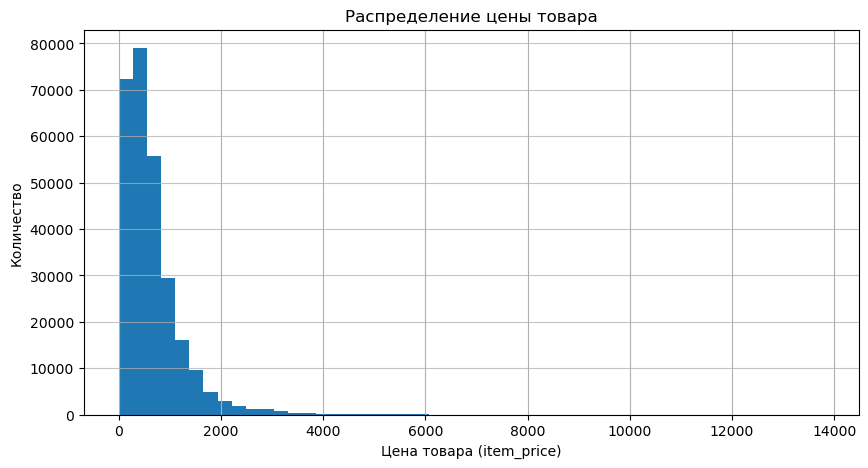

In [14]:
display(df_train['item_price'].describe())
plt.figure(figsize=(10, 5))
df_train['item_price'].hist(bins=50)
plt.xlabel('Цена товара (item_price)')
plt.ylabel('Количество')
plt.title('Распределение цены товара')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
df_train = df_train[~(df_train['item_price'] == 0)]

In [16]:
display(df_train['item_losses'].describe())

count    270860.000000
mean         24.049650
std          48.116271
min        -480.848430
25%           0.000000
50%           0.000000
75%          35.637760
max        1234.954697
Name: item_losses, dtype: float64

In [17]:
len(dt_train[dt_train['item_losses'] < 0])

4

In [18]:
len(dt_train[dt_train['item_losses'] > 300])

709

In [19]:
df_train = df_train[df_train['item_losses'] < 300]

In [20]:
df_train.loc[df_train['item_losses'] < 0, 'item_losses'] *= -1

count    270151.000000
mean         22.972240
std          42.672117
min           0.000000
25%           0.000000
50%           0.000000
75%          35.215931
max         480.848430
Name: item_losses, dtype: float64

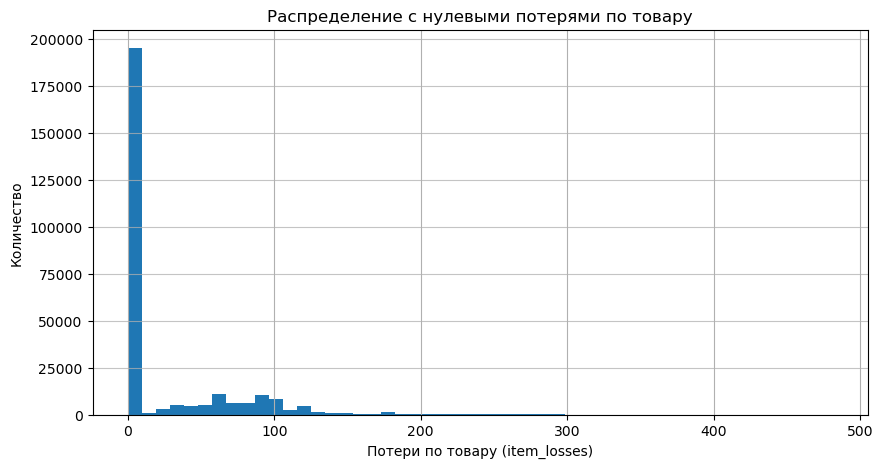

In [21]:
display(df_train[0 <= df_train['item_losses']]['item_losses'].describe())
plt.figure(figsize=(10, 5))
df_train[0 <= df_train['item_losses']]['item_losses'].hist(bins=50)
plt.xlabel('Потери по товару (item_losses)')
plt.ylabel('Количество')
plt.title('Распределение с нулевыми потерями по товару')
plt.grid(axis='y', alpha=0.75)
plt.show()

count    75215.000000
mean        82.509786
std         40.345499
min          3.127403
25%         58.037751
50%         80.812198
75%         99.849034
max        480.848430
Name: item_losses, dtype: float64

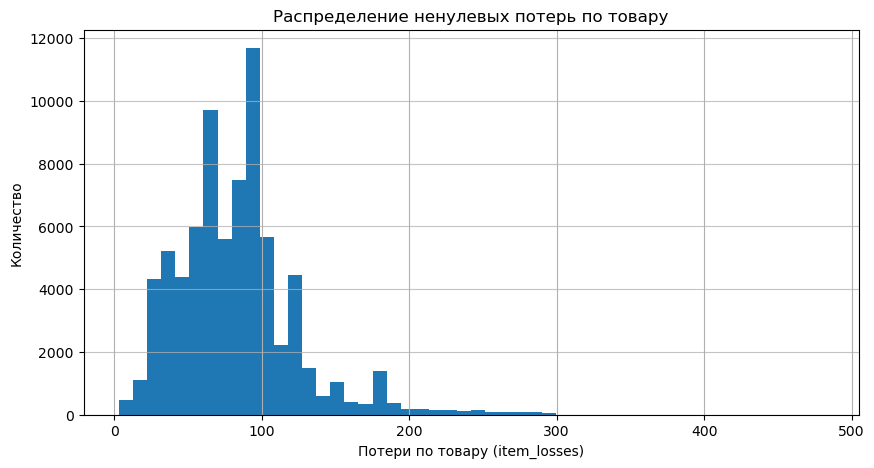

In [22]:
display(df_train[df_train["item_losses"] > 0]['item_losses'].describe())
plt.figure(figsize=(10, 5))
df_train[0 < df_train['item_losses']]['item_losses'].hist(bins=50)
plt.xlabel('Потери по товару (item_losses)')
plt.ylabel('Количество')
plt.title('Распределение ненулевых потерь по товару')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [23]:
df_train = preprocess_data(df_train)

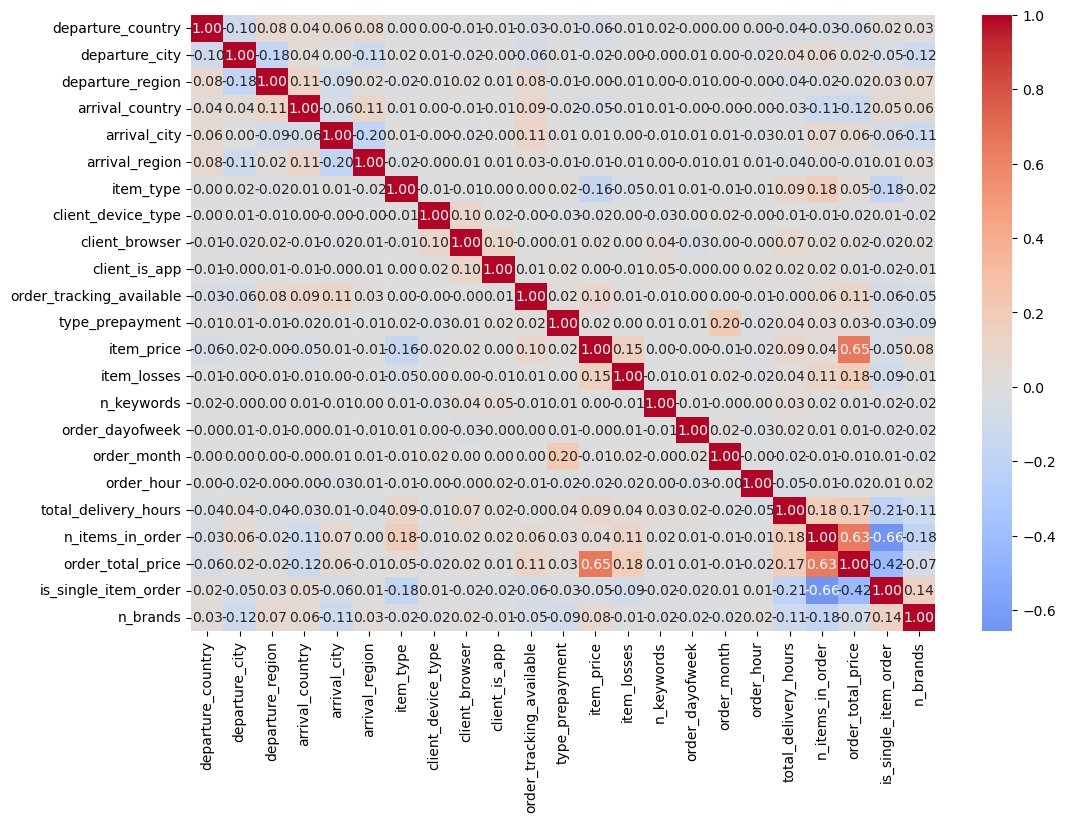

In [24]:
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot = True, center=0, fmt = '.2f')
plt.show()

In [25]:
df_train.isna().sum().sort_values()

order_id                           0
order_total_price                  0
n_items_in_order                   0
total_delivery_hours               0
order_hour                         0
order_month                        0
order_dayofweek                    0
n_keywords                         0
item_losses                        0
item_price                         0
type_prepayment                    0
delivery_service_name              0
item_category                      0
item_id                            0
brand_name                         0
is_single_item_order               0
order_tracking_available           0
item_package_type                  0
client_browser                     0
client_device_type                 0
item_type                          0
client_arrival_date                0
delivery_service_departure_date    0
stock_departure_date               0
order_date                         0
arrival_region                     0
arrival_city                       0
a

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270151 entries, 0 to 270150
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   order_id                         270151 non-null  object        
 1   departure_country                270151 non-null  int64         
 2   departure_city                   270151 non-null  int64         
 3   departure_region                 270151 non-null  int64         
 4   arrival_country                  270151 non-null  int64         
 5   arrival_city                     270151 non-null  int64         
 6   arrival_region                   270151 non-null  int64         
 7   order_date                       270151 non-null  datetime64[ns]
 8   stock_departure_date             270151 non-null  datetime64[ns]
 9   delivery_service_departure_date  270151 non-null  datetime64[ns]
 10  client_arrival_date              270151 non-

In [27]:
df_train.head(10)

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,...,item_losses,n_keywords,order_dayofweek,order_month,order_hour,total_delivery_hours,n_items_in_order,order_total_price,is_single_item_order,n_brands
0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565,466,12,162,888,2017-12-27 09:49:55,2018-01-02 00:48:00,2018-01-03 12:04:00,...,0.000000,3,2,12,9,176.318056,6,1818.824256,0,0
1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361,292,12,121,351,2016-10-17 21:17:17,2016-11-02 14:50:00,2016-11-02 21:33:00,...,0.000000,1,0,10,21,394.878611,2,1401.319814,0,2
2,d84abb0b-29f3-47bd-886e-c7cd3866bc7a,12,125,1666,12,634,530,2017-04-26 18:23:43,2017-05-06 21:15:00,2017-05-06 21:15:00,...,0.000000,0,2,4,18,246.221389,1,110.946960,1,2
3,5813b65b-1c55-4faf-83c8-4c1815498f49,12,507,263,12,171,1398,2017-07-01 20:02:55,2017-07-09 20:43:00,2017-07-09 20:43:00,...,0.000000,0,5,7,20,206.901389,1,793.902828,1,0
4,7907105b-fe87-412e-996c-bc1a27ae6c94,12,261,1597,12,125,1666,2017-05-31 18:18:31,2017-06-24 21:38:00,2017-06-25 03:42:00,...,119.655797,0,2,5,18,614.908056,1,1174.806858,1,2
5,2cc6c1a8-a300-4bec-a48d-28a6ac8f4e1e,3,481,865,12,121,36,2017-12-22 12:41:21,2017-12-23 20:51:00,2017-12-23 22:53:00,...,143.478261,0,4,12,12,42.594167,2,1864.207189,0,0
6,dd8fe2bf-15e1-4b1c-969b-f2268e5abf8a,12,121,1405,12,124,884,2017-09-05 17:02:35,2017-11-03 23:42:00,2017-11-03 23:42:00,...,39.680615,3,1,9,17,1429.373611,1,125.066997,1,0
7,4c237548-7f9a-4328-944d-2211f1f4555e,12,41,1447,12,451,280,2017-03-27 19:15:00,2017-04-09 12:40:00,2017-04-12 15:41:00,...,0.000000,0,0,3,19,392.533333,2,885.133449,0,0
8,2dc65a44-2f3f-40c1-9057-dcebc6f09327,12,121,856,12,597,1430,2017-05-31 10:45:09,2017-07-30 00:20:00,2017-07-30 00:20:00,...,0.000000,0,2,5,10,1504.130833,1,10388.099663,1,1
9,614376a4-eaab-4254-b8b6-d9bef570e5d3,12,121,36,1,93,41,2017-11-20 12:47:19,2018-01-02 17:55:00,2018-01-02 17:55:00,...,0.000000,0,0,11,12,1050.178056,1,1334.395426,1,1


## 3. Подготовка данных
- Обработка дат и категориальных признаков.
- Кодирование признаков и масштабирование.
- Выделение train/valid.

In [28]:
num_columns = [
    'item_price', 'order_total_price',
    'n_items_in_order', 'total_delivery_hours',
    'n_keywords', 'n_brands'
]

bin_columns = [
    'client_is_app', 'order_tracking_available', 'is_single_item_order'
]

cat_columns = [
    'client_browser', 'client_device_type',
    'item_type', 'item_category',
    'item_package_type', 'type_prepayment', 'order_month','order_hour', 'order_dayofweek'
]

In [45]:
class DataFrameColumnTransformer(ColumnTransformer):
    def get_feature_names_out(self, input_features=None):
        output_features = []
        for name, transformer, columns in self.transformers_:
            if transformer == 'passthrough':
                output_features.extend(columns)
            else:
                try:
                    output_features.extend(transformer.get_feature_names_out(columns))
                except:
                    output_features.extend(columns)
        return output_features

    def transform(self, X):
        X_out = super().transform(X)
        feature_names = self.get_feature_names_out()
        return pd.DataFrame(X_out, columns=feature_names, index=X.index)

In [46]:
preprocessor = DataFrameColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('bin', 'passthrough', bin_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_columns)
    ]
)

In [47]:
features = num_columns + bin_columns + cat_columns

target = 'item_losses'

In [48]:
X = df_train[features]
y = df_train[target]

In [49]:
y_bin = (y > 0).astype(int)

## 4. Постановка задачи и обучение
- Модель состоит из 2 этапов:
  1. Классификация (есть ли потери).
  2. Регрессесия (размер потерь при условии >0).
- Подбор гиперпараметров (LGBM).
- Ранжирование признаков.
- Выбор оптимального порога для классификатора.

### 1. Классификация

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [51]:
y_bin 

0         0
1         0
2         0
3         0
4         1
         ..
270146    1
270147    0
270148    0
270149    1
270150    0
Name: item_losses, Length: 270151, dtype: int64

In [52]:
pipe_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, verbosity=-1, warnings=False))
])

In [53]:
param_grid_clf = {
    'model__n_estimators': [100, 200, 500, 1000, 1500],
    'model__max_depth': [3, 5, 8, 12, 15, 20],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100, 120, 150],
    'model__min_data_in_leaf': [10, 20, 50],
    'model__feature_fraction': [0.7, 0.8, 0.9],
    'model__lambda_l1': [0, 0.5, 1],
    'model__lambda_l2': [0, 0.5, 1]
}

In [54]:
rnd_search_clf = RandomizedSearchCV(
    pipe_clf,
    param_distributions=param_grid_clf,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [55]:
rnd_search_clf.fit(X_train, y_bin.loc[X_train.index])

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              DataFrameColumnTransformer(transformers=[('num',
                                                                                        StandardScaler(),
                                                                                        ['item_price',
                                                                                         'order_total_price',
                                                                                         'n_items_in_order',
                                                                                         'total_delivery_hours',
                                                                                         'n_keywords',
                                                                                         'n_brands']),
                                                                                       ('bin',
                                                                                        'passthrough',
                                                                                        ['client_is_app',
                                                                                         'order_tracking_available',
                                                                                         'is_single_item_order']),
                                                                                       ('cat',
                                                                                        OneHotEncoder(handle...
                   param_distributions={'model__feature_fraction': [0.7, 0.8,
                                                                    0.9],
                                        'model__lambda_l1': [0, 0.5, 1],
                                        'model__lambda_l2': [0, 0.5, 1],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 8, 12, 15,
                                                             20],
                                        'model__min_data_in_leaf': [10, 20, 50],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000, 1500],
                                        'model__num_leaves': [31, 50, 100, 120,
                                                              150]},
                   random_state=30625, scoring='roc_auc')

In [56]:
best_clf = rnd_search_clf.best_estimator_

### 2. Регрессия

In [57]:
mask_positive = y > 0
X_reg = X[mask_positive]
y_reg = y[mask_positive]

X_train_reg, X_valid_reg, y_train_reg, y_valid_reg = train_test_split(
    X_reg, y_reg, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [58]:
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, verbosity=-1, warnings=False))
])

lgbm_param_grid = {
    'model__max_depth': [5, 10, 15, 20],
    'model__num_leaves': [31, 50, 100, 150, 200],
    'model__min_data_in_leaf': [10, 20, 50],
    'model__feature_fraction': [0.7, 0.8, 0.9],
    'model__lambda_l1': [0, 0.5, 1],
    'model__lambda_l2': [0, 0.5, 1],
    'model__n_estimators': [1000, 1500, 2000, 2500],
    'model__learning_rate': [0.005, 0.01, 0.05],
}

lgbm_search = RandomizedSearchCV(
    lgbm_pipe, lgbm_param_grid, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
)

lgbm_search.fit(X_train_reg, y_train_reg)
best_lgbm = lgbm_search.best_estimator_

In [66]:
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror', verbosity=0))
])

xgb_param_grid = {
    'model__n_estimators': [100, 200, 500, 1000, 1500],
    'model__max_depth': [3, 5, 8, 12, 15],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__reg_alpha': [0, 0.5, 1],
    'model__reg_lambda': [0, 0.5, 1],
    'model__gamma': [0, 0.1, 0.5]
}

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param_grid, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, error_score='raise'
)
xgb_search.fit(X_train_reg, y_train_reg)
best_xgb = xgb_search.best_estimator_


In [67]:
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm.named_steps['model']), ('xgb', best_xgb.named_steps['model'])],
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=True
)

In [68]:
stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack_model)
])


In [69]:
stack_pipe.fit(X_train_reg, y_train_reg)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 DataFrameColumnTransformer(transformers=[('num',
                                                           StandardScaler(),
                                                           ['item_price',
                                                            'order_total_price',
                                                            'n_items_in_order',
                                                            'total_delivery_hours',
                                                            'n_keywords',
                                                            'n_brands']),
                                                          ('bin', 'passthrough',
                                                           ['client_is_app',
                                                            'order_tracking_available',
                                                            'is_single_item_order']),
                                                          ('cat',
                                                           OneHotEncoder(handle_unknown='ignore',
                                                                         sparse_output=Fa...
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=12,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=LinearRegression(),
                                   n_jobs=-1, passthrough=True))])

In [70]:
p_positive = best_clf.predict_proba(X_valid)[:, 1]

In [71]:
thresholds = np.linspace(0, 1, 101) 
rmse_scores = []

for t in thresholds:
    mask_positive = (p_positive >= t)
    y_pred = np.zeros_like(y_valid)
    
    if mask_positive.sum() > 0: 
        y_pred[mask_positive] = stack_pipe.predict(X_valid[mask_positive])
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)


optimal_threshold = thresholds[np.argmin(rmse_scores)]
print(f'Оптимальный порог по RMSE: {optimal_threshold:.2f}')

Оптимальный порог по RMSE: 0.39


## 5. Комбинация результатов
- Предсказание `p_positive` (0/1).
- Предсказание регрессора.
- Итог: `y_valid_pred = p_positive * reg_pred`. `y_valid_pred` - это предсказание на валид. выборке после предсказаения класса и возможных потерь

In [72]:
p_positive = (p_positive >= optimal_threshold).astype(int)

reg_pred = stack_pipe.predict(X_valid)
y_valid_pred = p_positive * reg_pred


## 6. Оценка качества
- Метрика RMSE.
- Precision/Recall для класса 0.
- Confusion Matrix.

In [73]:
y_class_true = (y_valid > 0).astype(int)

precision_0 = precision_score(y_class_true, p_positive, pos_label=0)
recall_0 = recall_score(y_class_true, p_positive, pos_label=0)
print(f'Precision для класса 0: {precision_0:.3f}')
print(f"Recall для класса 1: {recall_0:.3f}")

cm = confusion_matrix(y_class_true, p_positive)
print('Confusion matrix:\n', cm)

Precision для класса 0: 0.824
Recall для класса 1: 0.943
Confusion matrix:
 [[45908  2790]
 [ 9794  9046]]


In [75]:
rmse_3stage = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("2-stage RMSE:", rmse_3stage);

2-stage RMSE: 41.575518298738054


## 7. Финальное предсказание на тесте
- Сохраняем `df_test` с колонкой `y_pred` в CSV.

In [76]:
df_test = preprocess_data(dt_test)[num_columns + bin_columns + cat_columns]

In [77]:
p_positive = best_clf.predict_proba(df_test)[:, 1]
p_positive = (p_positive >= optimal_threshold).astype(int)

reg_pred = stack_pipe.predict(df_test)
df_test['y_pred'] = p_positive * reg_pred

In [78]:
dt_test.shape

(77837, 25)

In [79]:
df_test.shape

(77837, 19)

In [80]:
dt_test['y_pred'] = df_test['y_pred']

In [81]:
df_test = dt_test

In [82]:
df_test

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,...,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,n_keywords,y_pred
0,3c39f09f-1f30-4d48-afd8-7ac959d4f2f3,12,125,824,12,121,1732,2018-05-15 14:41:20,2018-07-05 19:35:00,2018-07-05 19:35:00,...,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],340bd249-e659-4257-a2a3-c1eb8271183e,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,630.388722,0,0.000000
1,660eec62-8547-4e5c-9981-afd14f2466f4,12,642,635,12,193,215,2018-05-08 14:22:07,2018-07-26 03:32:00,2018-07-28 05:19:00,...,True,0,[],85272285-4549-45be-a4f9-9e74687a21f5,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1436.847481,0,0.000000
2,d12fe918-be12-42be-877d-4b10155d059c,12,193,215,12,642,635,2018-04-09 09:09:18,2018-07-07 17:50:00,2018-07-07 17:50:00,...,True,0,[],b3d43ea6-a053-4e03-8674-48ddd386fef9,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1508.838708,0,0.000000
3,0cf5d352-3bfd-42b4-a732-2c0207d8eb34,12,121,36,12,96,539,2018-05-26 17:29:52,2018-06-09 21:51:00,2018-06-09 21:51:00,...,True,0,['e5154844-2e6c-48ba-883b-2564eb8b8261'],21172dd4-a23e-4406-87e1-f76df576a02b,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,1,51.886309,3,25.262133
4,f24d4547-fe38-43cf-b307-45cb37e4d050,12,485,189,12,121,856,2018-03-14 13:49:42,2018-04-28 20:35:00,2018-04-28 20:35:00,...,True,0,[],783377c8-ae38-401f-901c-7b9710c0add4,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1182.162906,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77832,051b078d-0777-4dbe-98a1-5cb73cf53514,12,171,1398,12,713,1328,2018-05-28 16:03:40,2018-07-17 16:55:00,2018-07-18 20:16:00,...,True,0,['448196d7-6726-4824-9d03-4e2bca43e751'],30beb593-243a-44ed-a537-dd2ee46c01d6,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,0,604.727043,0,0.000000
77833,76048e92-7b91-469b-8f92-6049cd3fca7c,12,291,477,12,125,824,2018-03-21 22:43:28,2018-06-15 13:30:00,2018-06-15 13:30:00,...,True,0,[],4f41432a-edf8-4b61-94ba-207143ee80ac,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,1,683.406288,0,0.000000
77834,5d91cbbf-de25-4253-b52f-f105d9b8f03b,12,205,392,12,363,269,2018-05-04 16:42:58,2018-06-15 17:00:00,2018-06-15 17:00:00,...,True,0,[],4d5dbddb-28dd-45ed-a6bf-6d98e68a9aa8,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,1,578.132943,0,0.000000
77835,a19e2ab6-6ecc-42d9-9dfb-823cf90ffffb,12,125,824,12,402,347,2018-05-10 12:55:14,2018-05-14 20:41:00,2018-05-14 20:41:00,...,True,0,[],83f4a369-b51a-4467-9650-7bba8ac1fc39,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,717.017165,4,0.000000
